In [21]:
# ============================================================
# Notebook setup: run this before everything
# ============================================================

%load_ext autoreload
%autoreload 2

# Control figure size
interactive_figures = True
if interactive_figures:
    # Normal behavior
    %matplotlib widget
    figsize=(9, 3)
else:
    # PDF export behavior
    figsize=(14, 5)

#from matplotlib import pyplot as plt
from util import util
import igraph as ig
import numpy as np

# ============================================================
# Repeat the relevant previous steps
# ============================================================

# Generate a graph
g = util.build_website_graph(nnodes=4, rate=3, extra_arc_fraction=0.25, seed=42)
# Route flows (ground truth)
eoh = 4
flows, paths = util.build_random_paths(g, min_paths=3, max_paths=5,
                                          min_units=1, max_units=10, eoh=eoh, seed=10)
# Unfold
tug = util.build_time_unfolded_graph(g, eoh=eoh)
# Compute counts
node_counts, arc_counts = util.get_counts(tug, flows, paths)
# Apply counts
tugc = util.apply_weights(tug, node_counts, arc_counts)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Solving the Path Formulation

Which will be our baseline

## Solving the Path Formulation

**The path formulation consists in the Quadratic Program:**

$$
\arg \min_{x} \left\{\frac{1}{2} x^T P x + q^T x \mid x \geq 0 \right\}
$$

Where $P = V^T V + E^T E$ and $q = -V^T \hat{v} -E^T \hat{e}$

**Therefore, if we want to solve the problem we need:**

* The binary matrix $V$, s.t. $V_{ij} = 1$ iff node $i$ is in path $j$
* The binary matrix $E$, s.t. $E_{kj} = 1$ iff arc $k$ is in path $j$
* The vector $\hat{v}$, containing the node counts
* The vector $\hat{e}$, containing the arc counts

**In turn, to get these we need to define _a set of paths_ on the TUG**

## Path Enumeration

**Unless we want to loose optimality, we need to consider _all the TUG paths_**

First, we augment the Time Unfolded Graph with a _fake source node_

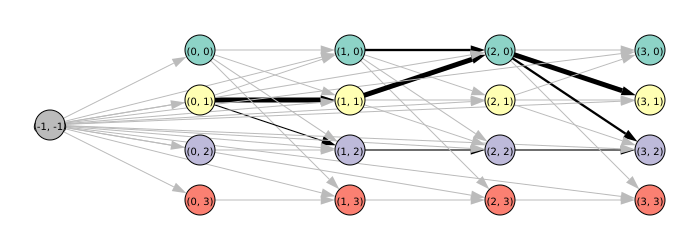

In [6]:
tugcs, tugcs_source = util._add_source_to_tug(tugc)
ig.plot(tugcs, **util.get_visual_style(tugcs), bbox=(700, 250), margin=50)

* The node is associate to the time step $-1$ and (original) index $-1$

## Path Enumeration

**Then we can use a _depth-first traversal_ to enumerate all paths**

In [9]:
tug_paths = util.enumerate_paths(tugcs, tugcs_source, exclude_source=True)
for i, p in enumerate(tug_paths):
    print(f'{i}: {p}')

0: [0]
1: [0, 4]
2: [0, 4, 8]
3: [0, 4, 8, 12]
4: [0, 4, 8, 13]
5: [0, 4, 8, 14]
6: [0, 4, 8, 15]
7: [0, 4, 9]
8: [0, 4, 9, 12]
9: [0, 4, 9, 13]
10: [0, 4, 9, 14]
11: [0, 4, 10]
12: [0, 4, 10, 14]
13: [0, 4, 11]
14: [0, 4, 11, 15]
15: [0, 5]
16: [0, 5, 8]
17: [0, 5, 8, 12]
18: [0, 5, 8, 13]
19: [0, 5, 8, 14]
20: [0, 5, 8, 15]
21: [0, 5, 9]
22: [0, 5, 9, 12]
23: [0, 5, 9, 13]
24: [0, 5, 9, 14]
25: [0, 5, 10]
26: [0, 5, 10, 14]
27: [0, 6]
28: [0, 6, 10]
29: [0, 6, 10, 14]
30: [0, 7]
31: [0, 7, 11]
32: [0, 7, 11, 15]
33: [1]
34: [1, 4]
35: [1, 4, 8]
36: [1, 4, 8, 12]
37: [1, 4, 8, 13]
38: [1, 4, 8, 14]
39: [1, 4, 8, 15]
40: [1, 4, 9]
41: [1, 4, 9, 12]
42: [1, 4, 9, 13]
43: [1, 4, 9, 14]
44: [1, 4, 10]
45: [1, 4, 10, 14]
46: [1, 4, 11]
47: [1, 4, 11, 15]
48: [1, 5]
49: [1, 5, 8]
50: [1, 5, 8, 12]
51: [1, 5, 8, 13]
52: [1, 5, 8, 14]
53: [1, 5, 8, 15]
54: [1, 5, 9]
55: [1, 5, 9, 12]
56: [1, 5, 9, 13]
57: [1, 5, 9, 14]
58: [1, 5, 10]
59: [1, 5, 10, 14]
60: [1, 6]
61: [1, 6, 10]
62: [1, 6, 10,

## Path Enumeratation

**By default we use TUG node indexes, but we can plot the original ones:**

In [10]:
tmp = util.tug_paths_to_original(tugcs, tug_paths)
for i, p in enumerate(tmp):
    print(f'{i}: {p}')

0: [(0, 0)]
1: [(0, 0), (1, 0)]
2: [(0, 0), (1, 0), (2, 0)]
3: [(0, 0), (1, 0), (2, 0), (3, 0)]
4: [(0, 0), (1, 0), (2, 0), (3, 1)]
5: [(0, 0), (1, 0), (2, 0), (3, 2)]
6: [(0, 0), (1, 0), (2, 0), (3, 3)]
7: [(0, 0), (1, 0), (2, 1)]
8: [(0, 0), (1, 0), (2, 1), (3, 0)]
9: [(0, 0), (1, 0), (2, 1), (3, 1)]
10: [(0, 0), (1, 0), (2, 1), (3, 2)]
11: [(0, 0), (1, 0), (2, 2)]
12: [(0, 0), (1, 0), (2, 2), (3, 2)]
13: [(0, 0), (1, 0), (2, 3)]
14: [(0, 0), (1, 0), (2, 3), (3, 3)]
15: [(0, 0), (1, 1)]
16: [(0, 0), (1, 1), (2, 0)]
17: [(0, 0), (1, 1), (2, 0), (3, 0)]
18: [(0, 0), (1, 1), (2, 0), (3, 1)]
19: [(0, 0), (1, 1), (2, 0), (3, 2)]
20: [(0, 0), (1, 1), (2, 0), (3, 3)]
21: [(0, 0), (1, 1), (2, 1)]
22: [(0, 0), (1, 1), (2, 1), (3, 0)]
23: [(0, 0), (1, 1), (2, 1), (3, 1)]
24: [(0, 0), (1, 1), (2, 1), (3, 2)]
25: [(0, 0), (1, 1), (2, 2)]
26: [(0, 0), (1, 1), (2, 2), (3, 2)]
27: [(0, 0), (1, 2)]
28: [(0, 0), (1, 2), (2, 2)]
29: [(0, 0), (1, 2), (2, 2), (3, 2)]
30: [(0, 0), (1, 3)]
31: [(0, 0), (1

## Building the Matrices and Vectors

**Now we can build the $V$ and $E$ matrices and the $\hat{v}$ and $\hat{e}$ vectors**

These define the least squares terms $\|Vx - \hat{v}\|_2^2$ and $\|Ex - \hat{e}\|_2^2$

In [14]:
V, E = util._paths_to_coefficient_matrices(tug, tug_paths)
v, e = util._counts_to_target_vectors(tug, node_counts, arc_counts)

Here's a visualization of the $V, \hat{v}$ pair:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
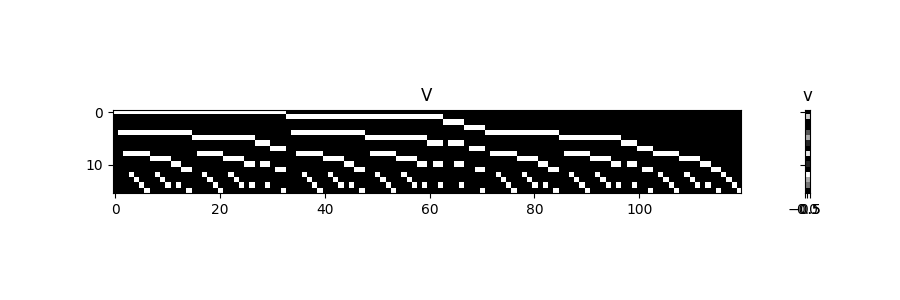

In [13]:
util.plot_matrix(V.toarray(), v, figsize=figsize, title='V', title_b='v')

## Building the Matrices and Vectors

**Now we can build the $V$ and $E$ matrices and the $\hat{v}$ and $\hat{e}$ vectors**

These define the least squares terms $\|Vx - \hat{v}\|_2^2$ and $\|Ex - \hat{e}\|_2^2$

In [14]:
V, E = util._paths_to_coefficient_matrices(tug, tug_paths)
v, e = util._counts_to_target_vectors(tug, node_counts, arc_counts)

Here's the same for the $E, \hat{e}$ pair:

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
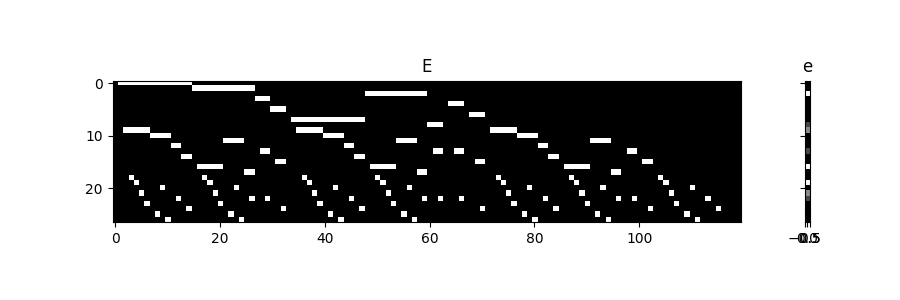

In [15]:
util.plot_matrix(E.toarray(), e, figsize=figsize, title='E', title_b='e')

## Solving the QP Problem

**The code for solving the QP is in the `solve_path_selection_full` function**

Here's a relevant snippet:

```python
# Enumerate all paths
tugs, tugs_source = _add_source_to_tug(tug)
paths = enumerate_paths(tugs, tugs_source, exclude_source=True)
# Build the path selection solver
prb = PathSelectionSolver(tug, node_counts, arc_counts)
# Solve the path selection problem
sol = prb.solve(paths, verbose=verbose, polish=True, **settings)
```

* First we build a `PathSelectionSolver`, i.e. a custom class from the `util` module
* Then we call the `solve` method
* With `polish = True` we attempt to obtain an exact solution
* Otherwise, we get a (feasible, but) approximate solution

## Solving the QP Problem

**In turn, `PathSelectionSolver.solve` contains the following code:**

```python
# Build the solver
self.mdl = osqp.OSQP()
# Recompute the problem matrices
P, q, A, l, u = self._recompute_matrices(paths)
# Setup the solver
self.mdl.setup(P=P, q=q, A=A, l=l, u=u, **settings)
# Solve the problem
sol = self.mdl.solve()
```
This is how we use the actual OSQP solver

* We build an `OSQP` object, we call `setup`, then we cal `solve`
* ...But first we need to compute the terms $P, q, A, l, u$

## Solving the QP Problem

**Matrix construction happens in the `_recompute_matrices` function**

We already know that:

$$
P = V^T V + E^T E \quad \text{and} \quad q = -V^T \hat{v} -E^T \hat{e}
$$

* Where $V$ and $E$ specify which nodes/arcs belong to each path
* ...And $\hat{v}$ and $\hat{e}$ are the counts for all TUG nodes and arcs

About the $A$ matrix and $l$ and $u$ vectors

* They are meant to specify the problem constraints
* Since in our problem we have $x \geq 0$, then:

$$
A = I \quad \text{and} \quad l = 0 \quad \text{and} \quad u = +\infty
$$

## Solving the QP Problem

**Let's actually solve the problem and inspect the output**

In [17]:
rflows, rpaths = util.solve_path_selection_full(tug, node_counts, arc_counts, verbose=1)

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 120, constraints m = 120
          nnz(P) + nnz(A) = 3520
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: on, time_limit: off

iter   objective    pri res    dua res    rho        time
   1  -1.5048e+02   4.34e-01   1.81e+01   1.00e-01   9.66e-04s
  50  -1.9458e+02   7.04e-04   4.24e-02   1.00e-01   2.59e-03s
plsh  -1.9460e+02   1.82e-16   2.95e-14   ---

## Inspecting the Solution

**The raw solver log does not relate much to our specific problem**

But we can obtain clearer plots using some ad-hoc built functions:

In [22]:
print('FLOW: PATH')
util.print_solution(tug, rflows, rpaths, sort='descending')
sse = util.get_reconstruction_error(tug, rflows, rpaths, node_counts, arc_counts)
print(f'\nRSSE: {np.sqrt(sse):.2f}')

FLOW: PATH
9.58: 3,0
3.40: 0,1 > 1,1 > 2,0 > 3,1
2.05: 0,1 > 1,1 > 2,0 > 3,2
2.05: 1,0 > 2,0 > 3,1
1.23: 0,1 > 1,2 > 2,2 > 3,2
0.47: 1,0 > 2,0 > 3,2

RSSE: 0.00


* We know see which paths have been used to "reconstruct" the counts
* The corresponding estimated flows
* And the Root Sum of Squared Errors